# Uber Data Analysis

Welcome! This project serves to practice and demonstrate my skills in exploratory data analysis and modelling of high-dimensional data. For now, this notebook is a WIP!

## Loading Data 💿

Before any analysis, we must load the data using pandas. First, we wanna simplify the data for further analysis and make sure that the data is complete.

In [11]:
import pandas as pd

apr14 = pd.read_csv("../Data/uber-raw-data-apr14.csv", parse_dates=['Date/Time'])
may14 = pd.read_csv("../Data/uber-raw-data-may14.csv", parse_dates=['Date/Time'])
jun14 = pd.read_csv("../Data/uber-raw-data-jun14.csv", parse_dates=['Date/Time'])
jul14 = pd.read_csv("../Data/uber-raw-data-jul14.csv", parse_dates=['Date/Time'])
aug14 = pd.read_csv("../Data/uber-raw-data-aug14.csv", parse_dates=['Date/Time'])
sep14 = pd.read_csv("../Data/uber-raw-data-sep14.csv", parse_dates=['Date/Time'])

combined_data = pd.concat([apr14, may14, jun14, jul14, aug14, sep14])

In [14]:
combined_data['Weekday Name'] = pd.to_datetime(combined_data['Date/Time']).dt.day_name()
combined_data['Day'] = pd.to_datetime(combined_data['Date/Time']).dt.day
combined_data['Hour'] = pd.to_datetime(combined_data['Date/Time']).dt.hour
combined_data['Minute'] = pd.to_datetime(combined_data['Date/Time']).dt.minute
combined_data['Month'] = pd.to_datetime(combined_data['Date/Time']).dt.month
combined_data.head()

,Date/Time,Lat,Lon,Base,Weekday Name,Day,Hour,Minute,Month
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,Tuesday,1,0,11,4
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,Tuesday,1,0,17,4
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,Tuesday,1,0,21,4
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,Tuesday,1,0,28,4
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,Tuesday,1,0,33,4


In [15]:
month_name = {4:"April", 5: "May", 6:"June", 7:"July", 8:"August", 9:"September"}

## A deeper look at our data

In [29]:
print(combined_data.dtypes)

Date/Time       datetime64[ns]
Lat                    float64
Lon                    float64
Base                    object
Weekday Name            object
Day                      int64
Hour                     int64
Minute                   int64
Month                    int64
dtype: object


In [24]:
print(combined_data.shape)

(4534327, 9)


In [30]:
print(combined_data.isna().values.any())

False


Here we can see that our data has around 4.5 Million entries and does not contain any NA values. We also see that we have the columns Lat, Lon, Base, Weekday Name, Day, Hour, Minute and Month which can be used for further data analysis. 

## Amount of Trips between Month 🚘

At first, let's take a look at how many rides have been taken in each month. We can simply visualize this with a bar plot.

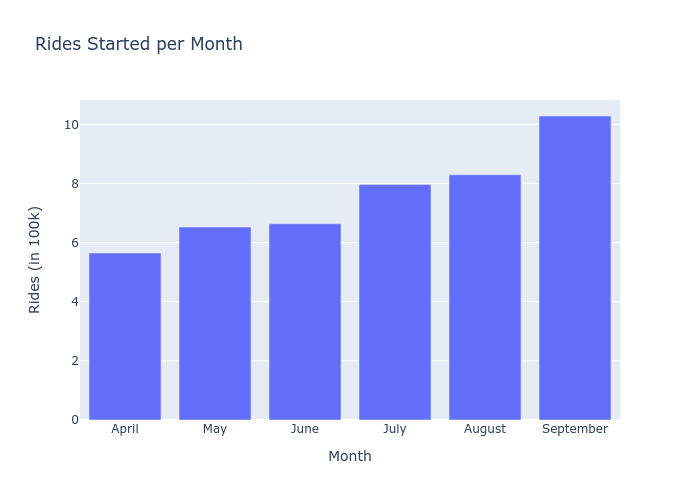

In [41]:
import plotly.express as px
import numpy as np
import plotly.io as pio

pio.renderers.default = "png"

bar_plot = px.bar(y = combined_data.groupby(['Month']).size()/100000, 
                  x = ["April", "May", "June", "July", "August", "September"], 
                  title = "Rides Started per Month")

bar_plot.update_yaxes(title = "Rides (in 100k)")
bar_plot.update_xaxes(title = "Month")
bar_plot.show()

We can see an increase in rides from April to September. It is hard to explain this without any more data. However, for now it might be easiest to guess that it has to do with more people going out when the weather is better - in the summer months.

## Time of Trips ⏰

Next, it seems like a good idea to gain an overview of the time when the trips occur. It is to expect that we can see increased rides in the evening (going out, etc...). But for now, let's look at trips per day.

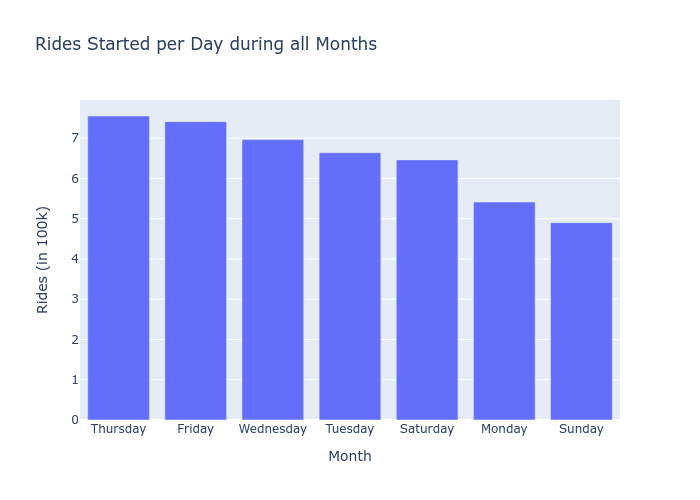

In [40]:
bar_plot = px.bar(y = combined_data.groupby(['Weekday Name']).size()/100000, 
                  x = combined_data.groupby(['Weekday Name']).size().index, 
                  title = "Rides Started per Day during all Months")

bar_plot.update_yaxes(title = "Rides (in 100k)")
bar_plot.update_xaxes(title = "Month")
bar_plot.update_layout(xaxis={'categoryorder':'total descending'})
bar_plot.show()

Surprisingly, Thursday and Friday record the highest number of trips started over all months. This is unexpected, as one would assume that there would also be a high demand for rides on Saturdays. This means, most Uber pickups are likely to be work related. Sunday and Monday are by far the least busy which can be explained since Sunday/Monday are commonly the least busy days of the week. To improve the plot, we can split each weekday into the number of trips that are started per month per weekday.

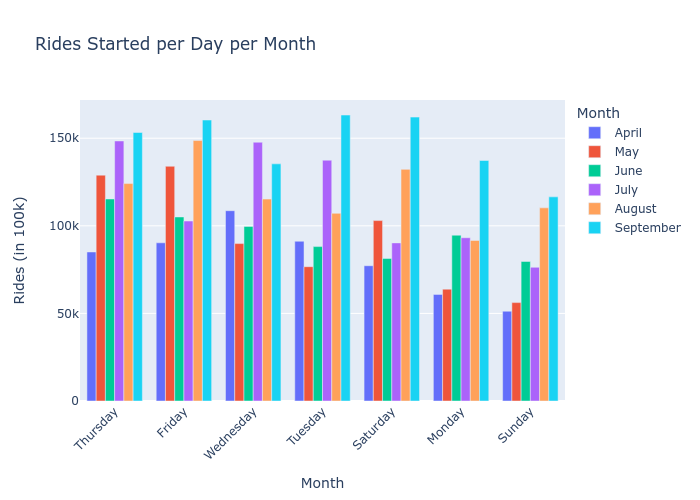

In [85]:
day_month_split = combined_data.groupby(['Weekday Name', 'Month']).size().unstack()
y_plot = [day_month_split.iloc[:,i] for i in range(6)]

newnames = {'wide_variable_0':'April', 'wide_variable_1': 'May','wide_variable_2': 'June',
            'wide_variable_3': 'July','wide_variable_4': 'August', 'wide_variable_5': 'September'}

bar_plot = px.bar(y = y_plot, 
                  x = day_month_split.index, 
                  title = "Rides Started per Day per Month")

bar_plot.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])))

bar_plot.update_yaxes(title = "Rides (in 100k)")
bar_plot.update_xaxes(title = "Month")
bar_plot.update_layout(barmode='group', xaxis_tickangle=-45,xaxis={'categoryorder':'total descending'},
                       legend_title="Month")
bar_plot.show()

## How are trips distributed throughout the day?

After seeing that certain days and months have more trips started than others, let's take a look at the distribution of the trips throughout the day.

In [3]:
from calendar import monthrange

apr14_hours = apr14.groupby(apr14.iloc[:,0].dt.hour).size()/monthrange(2014,4)[1]
may14_hours = may14.groupby(may14.iloc[:,0].dt.hour).size()/monthrange(2014,5)[1]
jun14_hours = jun14.groupby(jun14.iloc[:,0].dt.hour).size()/monthrange(2014,6)[1]
jul14_hours = jul14.groupby(jul14.iloc[:,0].dt.hour).size()/monthrange(2014,7)[1]
aug14_hours = aug14.groupby(aug14.iloc[:,0].dt.hour).size()/monthrange(2014,8)[1]
sep14_hours = sep14.groupby(sep14.iloc[:,0].dt.hour).size()/monthrange(2014,9)[1]





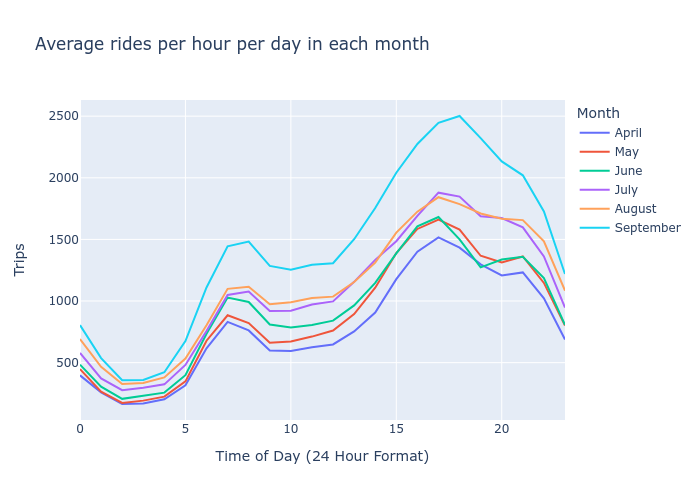

In [4]:
line_plot = px.line(y=[apr14_hours, may14_hours, jun14_hours, jul14_hours, aug14_hours, sep14_hours],
                    x=range(0, 24),title='Average rides per hour per day in each month')

newnames = {'wide_variable_0':'April', 'wide_variable_1': 'May','wide_variable_2': 'June',
            'wide_variable_3': 'July','wide_variable_4': 'August', 'wide_variable_5': 'September'}
line_plot.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])))

line_plot.update_layout(legend_title="Month")

line_plot.update_xaxes(title = "Time of Day (24 Hour Format)")
line_plot.update_yaxes(title = "Trips")

line_plot.show()

We can see that we have a peak at around 8AM which can be explained by work related transit. Then, the amount of trips per hour stay high from around 4PM to 9PM. This is presumably because of work related transit as well as evening events. But this is a very shallow analysis. Let's dive deeper.

## For-Fun: Model average 

From the plot above we can see that the Trips per hour for one month can be modelled relatively accurately with a simple polynomial. I will choose a 7th degree polynomial. (This step is supposed to be a 'proof-of-concept' - less an actual analysis)


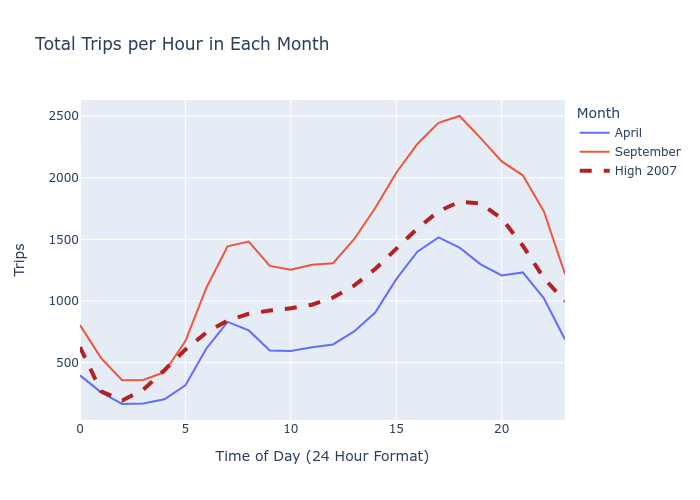

In [5]:
import plotly.graph_objects as go

avg_hours = (apr14_hours+may14_hours+jun14_hours+jul14_hours+aug14_hours+sep14_hours)/6
model = np.poly1d(np.polyfit(range(0,24), avg_hours, 7))

model_pred = model(range(0,24))

line_plot = px.line(y=[apr14_hours,sep14_hours],
                    x=np.array(range(0, 24)),title='Total Trips per Hour in Each Month')

newnames = {'wide_variable_0':'April', 'wide_variable_1': 'September'}
line_plot.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])))

line_plot.add_trace(go.Scatter(x=np.array(range(0,24)), y=model_pred, name='High 2007',
                         line=dict(color='firebrick', width=4,
                              dash='dash')))

line_plot.update_layout(legend_title="Month")

line_plot.update_xaxes(title = "Time of Day (24 Hour Format)")
line_plot.update_yaxes(title = "Trips")
line_plot.show()

We can see that the model seems to accurately display the average. Cool that it works, but that's it. :) 

## What about Bases?

Bases describe which sub-contractor actually dispatched the uber. Let's just take a look at the absolute number of cars dispatched form each base in each month.

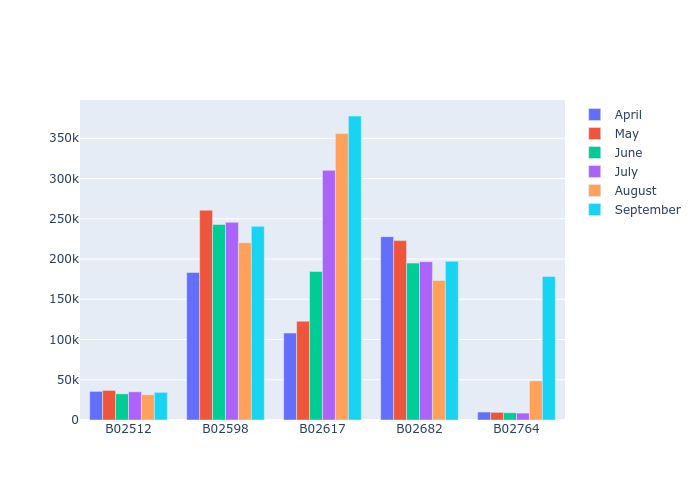

In [122]:
base_month = combined_data.groupby(["Base", "Month"]).size().unstack()

plot_parts = [go.Bar(name = month_name[base_month.iloc[:,i].name], y = base_month.iloc[:,i], x = base_month.iloc[:,i].index) for i in range(6)]

bar_plot = go.Figure(data = plot_parts)

bar_plot.show()

# Can we visualize it differently?

We see that ...
The bar plot is giving us a general overview but is not allowing us to compare the use of different bases across different month. Let's fix that:

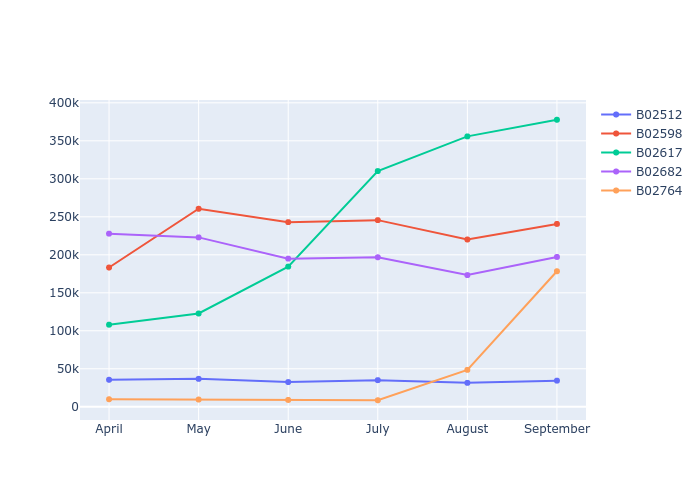

In [121]:
plot_parts = [go.Scatter(name = base_month.iloc[i,:].name, y = base_month.iloc[i,:], x = [month_name[ind] for ind in base_month.iloc[i,:].index]) for i in range(5)]

line_plot = go.Figure(data = plot_parts)

line_plot.show()

# What about the location?

For now we have only focused on the number of rides, but where are most rides started at? We can use a heatmap to visualize this question. To reduce the load of data we are passing to folium we will only focus on the day with the most rides. From prior analysis we know that this day is Thursday.

In [131]:
import folium
from folium.plugins import HeatMap

map = folium.Map(location=[40.7128, -74.0060],
                    zoom_start = 11)


thursday_heat = combined_data.loc[combined_data['Weekday Name'] == "Thursday"]
thursday_heat.shape
#heat_plot = [[row['Lat'],row['Lon']] for index, row in thursday_heat.iterrows()]
print(heat_plot)
#HeatMap(apr14_heat_plot).add_to(map)


#map

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

